# Preprocessing of the data

In [1]:
%load_ext autoreload
%autoreload 2

# Imports
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import numpy as np

In [2]:
# Custom imports
from src.preprocessing.utils import read_dicom_series, image_to_array, array_to_image
from src.preprocessing.preprocessing import downsample_image, reverse_slice_order, cutout_cast_HR_pQCT, cutout_calibration_phantom, outlier_elimination, reorient_PCCT_image, intensity_normalization, threshold_image
from src.preprocessing.multi_part_image import split_series, merge_series, merge_sitk_images

## HR-pQCT Images


In [3]:
# As the HR-pQCT images are very large, we will downsample them to a more manageable size
# Further as my machine does not have enough memory to load all the images at once, we will
# downsample them in batches of 3.

HR_pQCT_image_path = r"C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L"


In [4]:
# Split the image into 3 parts
path_to_subfolders = split_series(HR_pQCT_image_path, 3)
print(path_to_subfolders)

['C:\\Users\\Yannick\\Documents\\repos\\deep_femur_segmentation\\data\\HR-pQCT\\2211_07114_L\\part_0', 'C:\\Users\\Yannick\\Documents\\repos\\deep_femur_segmentation\\data\\HR-pQCT\\2211_07114_L\\part_1', 'C:\\Users\\Yannick\\Documents\\repos\\deep_femur_segmentation\\data\\HR-pQCT\\2211_07114_L\\part_2']


### Load and downsample images in 3 batches

['C:\\Users\\Yannick\\Documents\\repos\\deep_femur_segmentation\\data\\HR-pQCT\\2211_07114_L\\part_0', 'C:\\Users\\Yannick\\Documents\\repos\\deep_femur_segmentation\\data\\HR-pQCT\\2211_07114_L\\part_1', 'C:\\Users\\Yannick\\Documents\\repos\\deep_femur_segmentation\\data\\HR-pQCT\\2211_07114_L\\part_2']


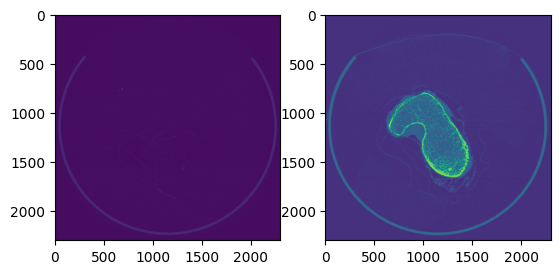

 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_0, size: (2304, 2304, 727), spacing: (0.06069965, 0.06069965, 0.06069999999999998)
 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_0, size: (1152, 1152, 363), spacing: (0.1213993, 0.1213993, 0.12139999999999997)


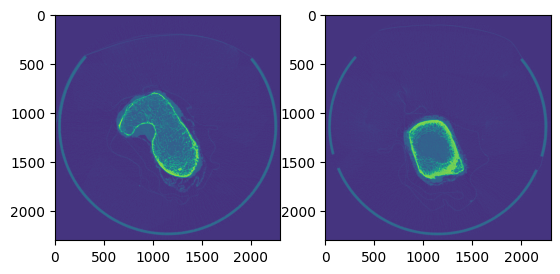

 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_1, size: (2304, 2304, 727), spacing: (0.06069965, 0.06069965, 0.06069999999999998)
 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_1, size: (1152, 1152, 363), spacing: (0.1213993, 0.1213993, 0.12139999999999997)


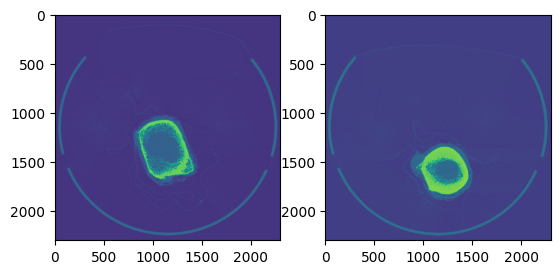

 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_2, size: (2304, 2304, 726), spacing: (0.06069965, 0.06069965, 0.06070000000000003)
 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_2, size: (1152, 1152, 363), spacing: (0.1213993, 0.1213993, 0.12140000000000006)


In [5]:
path_to_subfolders = os.listdir(HR_pQCT_image_path)
path_to_subfolders = [os.path.join(HR_pQCT_image_path, path) for path in path_to_subfolders if path.startswith("part")]
print(path_to_subfolders)
down_sampled_images = []
for path in path_to_subfolders:
    image = read_dicom_series(path)
    # display the first and last slice of the image
    fig, ax = plt.subplots(1,2)
    sitk.GetArrayFromImage
    ax[0].imshow(sitk.GetArrayFromImage(image[:,:,0]))
    ax[1].imshow(sitk.GetArrayFromImage(image[:,:,-1]))
    plt.show()

    print(f" path: {path}, size: {image.GetSize()}, spacing: {image.GetSpacing()}")

    # Downsample the image
    image = downsample_image(image, 2)

    print(f" path: {path}, size: {image.GetSize()}, spacing: {image.GetSpacing()}")

    down_sampled_images.append(image)

 path: C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\HR-pQCT\2211_07114_L\part_2, size: (1152, 1152, 1089), spacing: (0.1213993, 0.1213993, 0.12139999999999997)


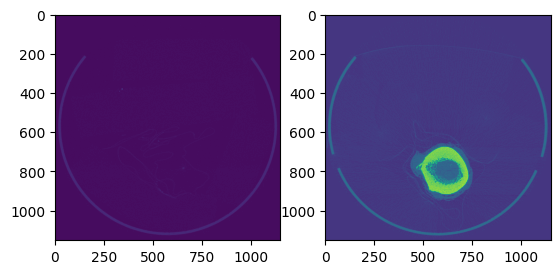

In [6]:
# merge the images back together
image = merge_sitk_images(down_sampled_images)
print(f" path: {path}, size: {image.GetSize()}, spacing: {image.GetSpacing()}")
# display the first and last slice of the image
fig, ax = plt.subplots(1,2)
ax[0].imshow(sitk.GetArrayFromImage(image[:,:,0]))
ax[1].imshow(sitk.GetArrayFromImage(image[:,:,-1]))
plt.show()

### Remove the Cast

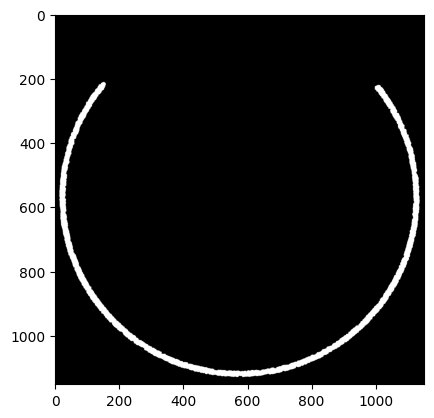

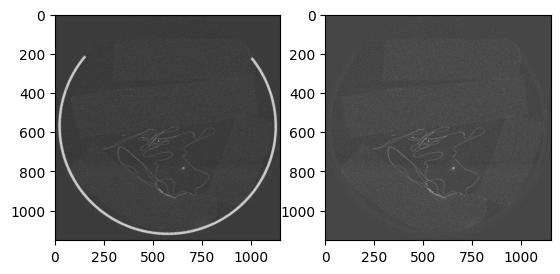

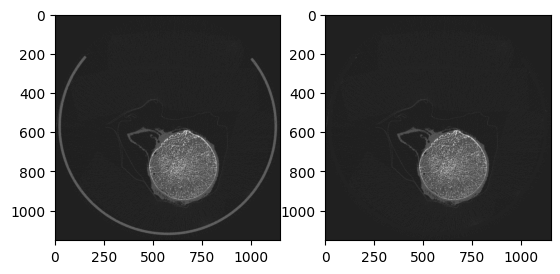

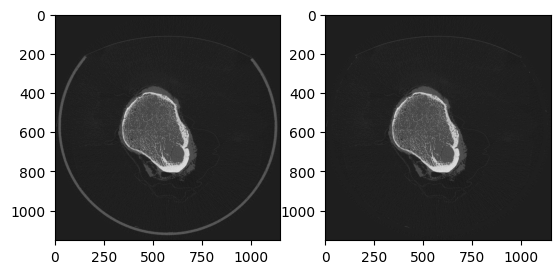

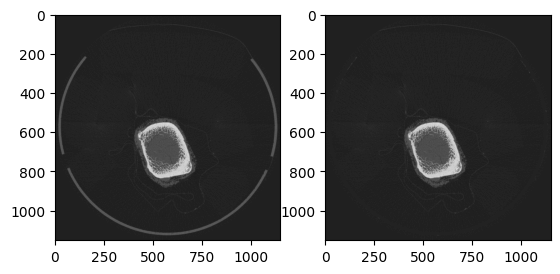

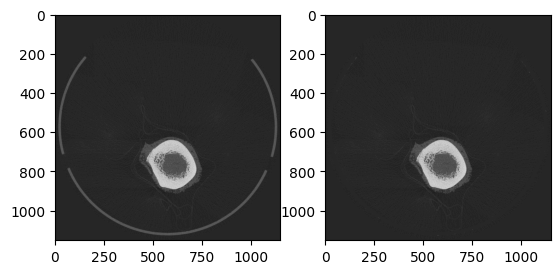

In [52]:
no_cast, mask = cutout_cast_HR_pQCT(image[:,:,::50])

plt.imshow(mask[:,:,0], cmap="gray")
plt.show()

#  Show the first slice of the image
for i in range(0, no_cast.GetDepth(), 5):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(sitk.GetArrayFromImage(image[:,:,i*50]), cmap="gray")
    ax[1].imshow(sitk.GetArrayFromImage(no_cast[:,:,i]), cmap="gray")
    plt.show()

image, _ = cutout_cast_HR_pQCT(image)

In [8]:
image = intensity_normalization(image)

In [9]:
# Set Direction and Origin
image.SetDirection([1,0,0,0,1,0,0,0,1])
image.SetOrigin([0,0,0])

In [56]:
sitk.WriteImage(image_hq, os.path.join(HR_pQCT_image_path, "downsampled_image_cut.nii.gz"))

## PCCT preprocessing

In [3]:
PCCT_image_path = r"C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\PCCT\2211_07114_L\Ex_vivo_bone_0_20_Br89_Q3_L_7"

In [12]:
image = read_dicom_series(PCCT_image_path)
print(image.GetDirection())
print(image.GetOrigin())
print(image.GetSpacing())
print(image.GetSize())


(-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(61.16605859375, 170.93505859375, -1559.439)
(0.1298828125, 0.1298828125, 0.10000000000000003)
(1024, 1024, 4709)


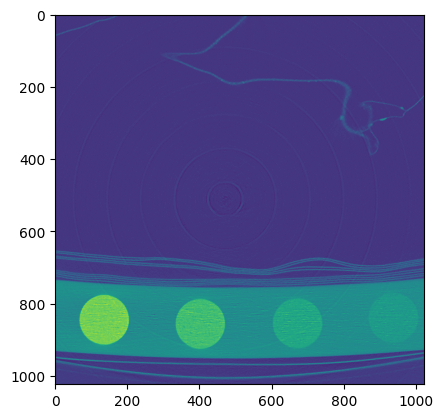

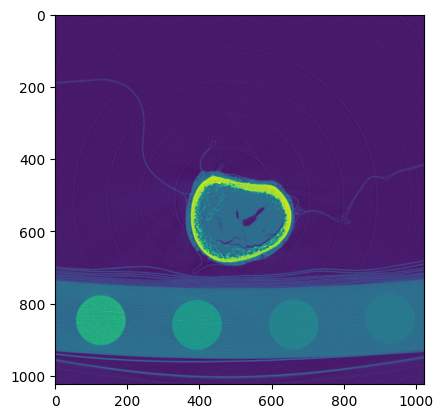

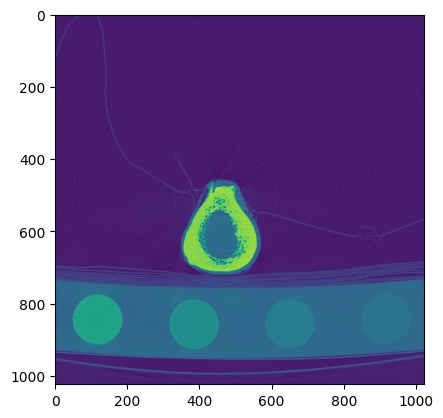

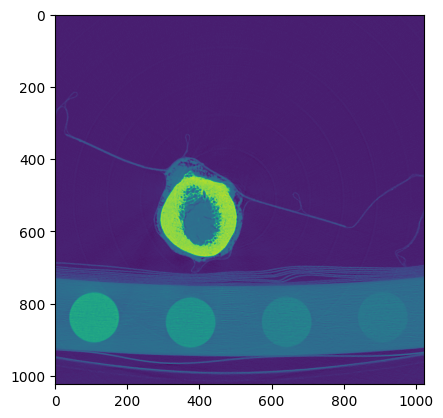

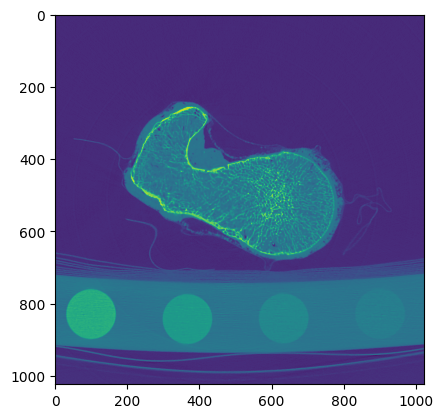

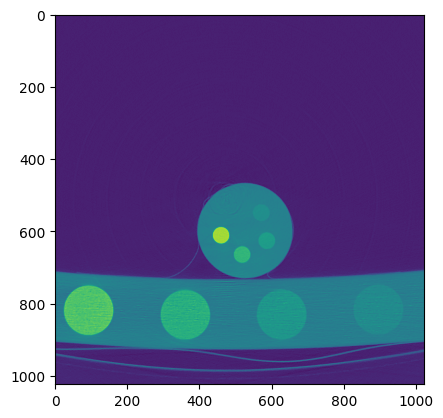

In [13]:
# Display some slices of the image
for i in range(0, image.GetDepth(), 1000):
    plt.imshow(sitk.GetArrayFromImage(image[:,:,i]))
    plt.show()
plt.imshow(sitk.GetArrayFromImage(image[:,:,-1]))
plt.show()



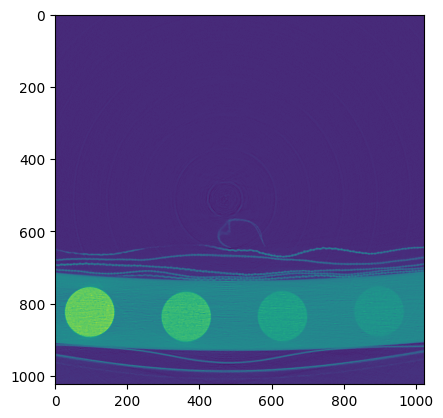

In [14]:
# Cut away last slices with the calibration phantom
image = image[:,:,:image.GetDepth()-300]
# Display last slice
plt.imshow(sitk.GetArrayFromImage(image[:,:,image.GetDepth()-1]))

In [15]:
# Cut out the calibration phantom
image_cut = cutout_calibration_phantom(image)

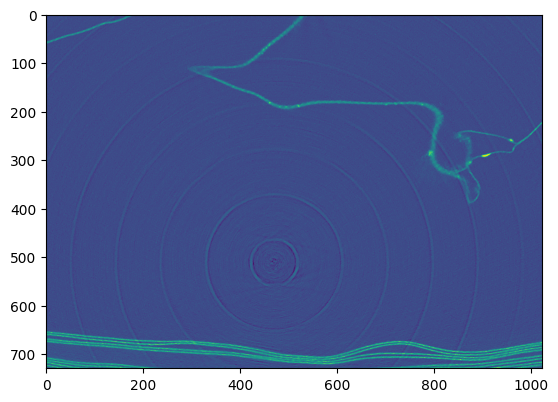

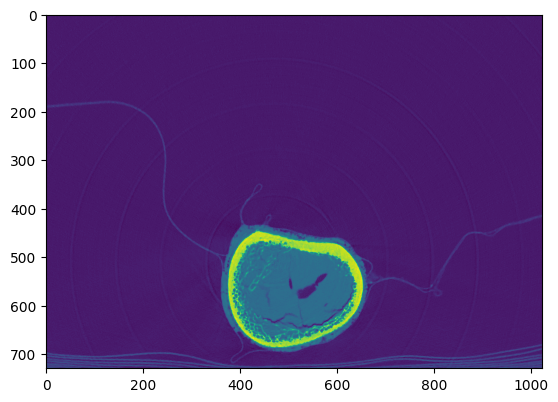

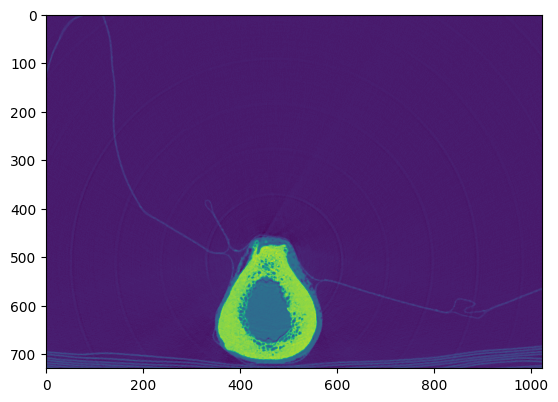

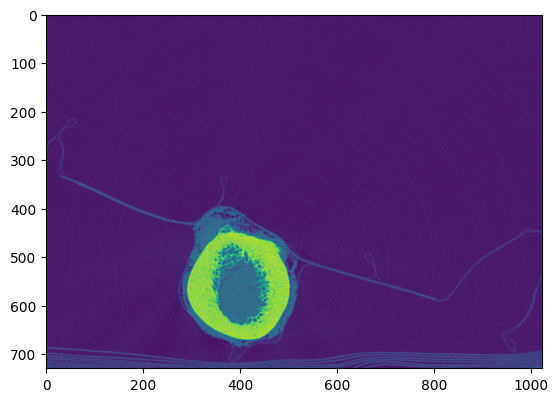

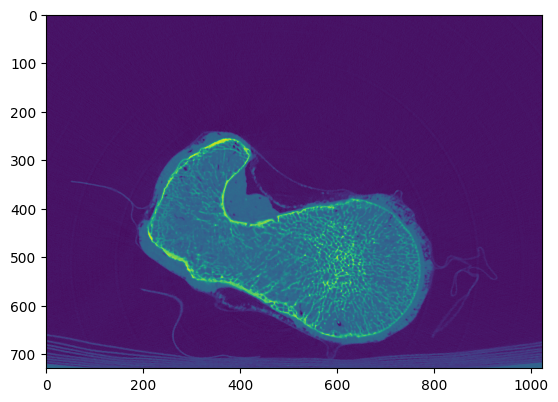

In [16]:
for i in range(0, image_cut.GetDepth(), 1000):
    plt.imshow(sitk.GetArrayFromImage(image_cut[:,:,i]))
    plt.show()

In [17]:
# Reorient the image to fit the HR-pQCT image
image_cut = reorient_PCCT_image(image_cut)


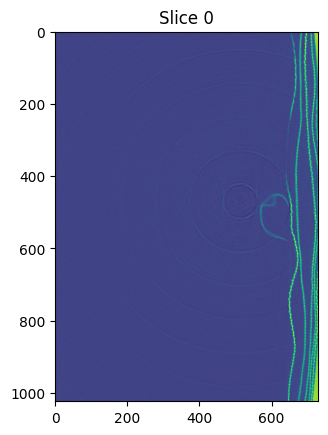

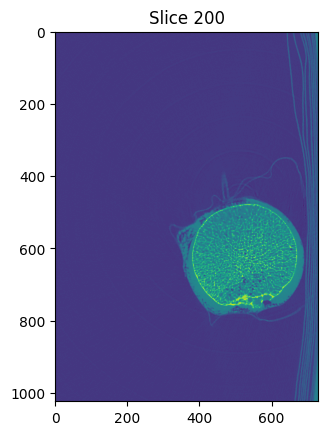

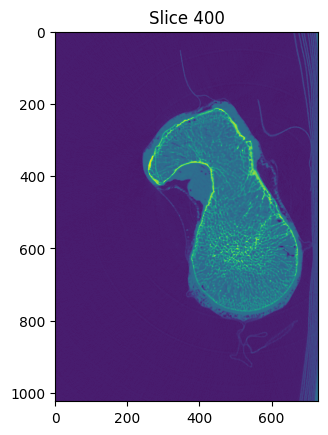

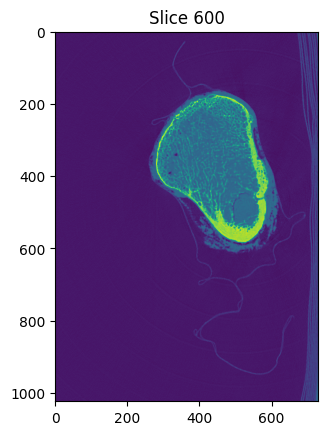

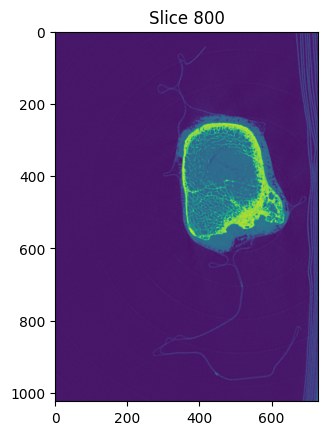

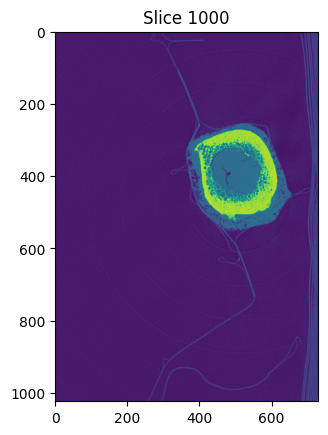

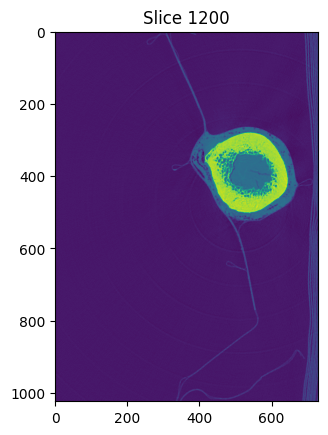

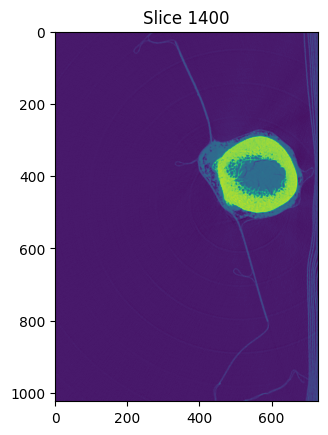

In [19]:
array = sitk.GetArrayFromImage(image_cut)
array = array[:,::-1,:]
image_cut = sitk.GetImageFromArray(array)
image_cut.SetSpacing(image.GetSpacing())
image_cut.SetDirection(image.GetDirection())
image_cut.SetOrigin(image.GetOrigin())

for i in range(0, image_cut.GetDepth(), 200):
    plt.imshow(sitk.GetArrayFromImage(image_cut[:,:,i]))
    plt.title(f"Slice {i}")
    plt.show()

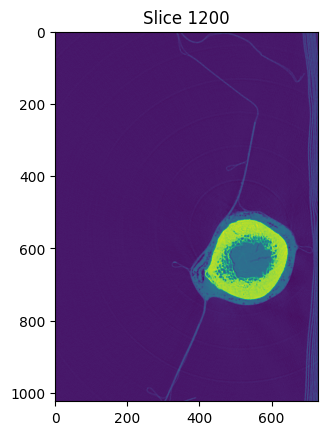

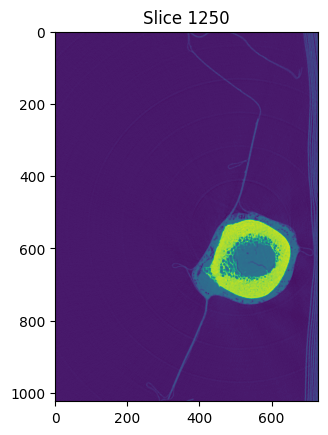

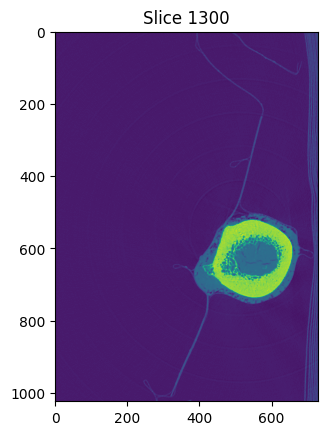

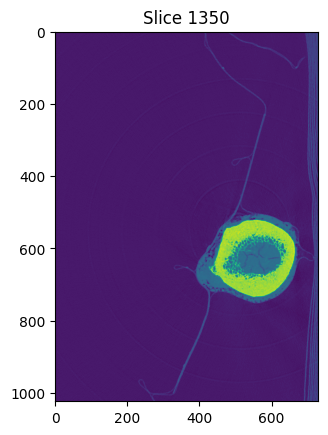

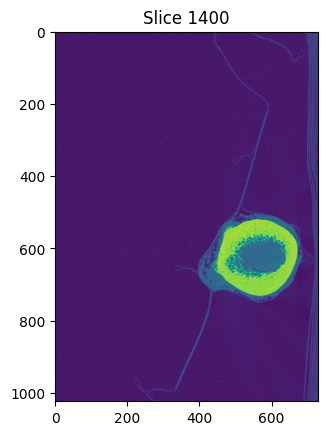

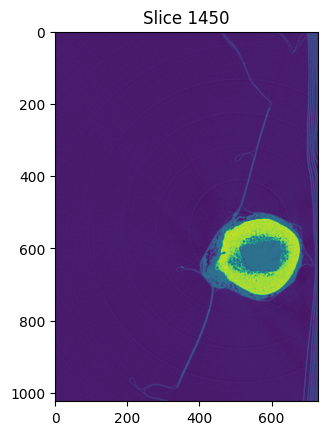

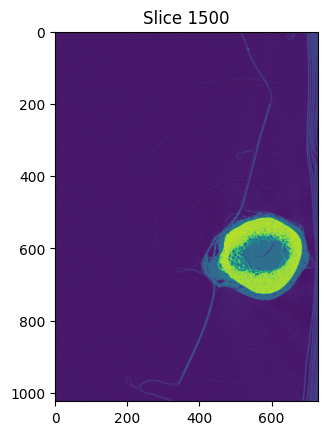

IndexError: index 1550 is outside the extent for dimension 2 with size 1550

In [9]:
# Cut out the lower part of the image that is not needed

for i in range(1200, 1800, 50):
    plt.imshow(sitk.GetArrayFromImage(image_cut[:,:,i]))
    plt.title(f"Slice {i}")
    plt.show()

In [20]:
image_cut = image_cut[:,:,:1550]

In [21]:
image_cut = intensity_normalization(image_cut)

In [20]:
image_cut.SetDirection([1,0,0,0,1,0,0,0,1])
image_cut.SetOrigin([0,0,0])


In [21]:
sitk.WriteImage(image_cut, os.path.join(PCCT_image_path, "cutout_calibration_phantom.nii.gz"))

In [4]:
image = sitk.ReadImage(os.path.join(PCCT_image_path, "cutout_calibration_phantom.nii.gz"))

In [28]:
image_hq = sitk.ReadImage(os.path.join(HR_pQCT_image_path, "downsampled_image_cut.nii.gz"))

In [59]:
sitk.WriteImage(thres, os.path.join(HR_pQCT_image_path, "downsampled_image_cut_97.nii.gz"))

In [22]:

thres = threshold_image(intensity_normalization(image_cut), fraction=0.97, sparse=True)

Threshold value: 941.9733574170242
Number of voxels above threshold: 34845489
Fraction of voxels above threshold: 0.03007405908224702


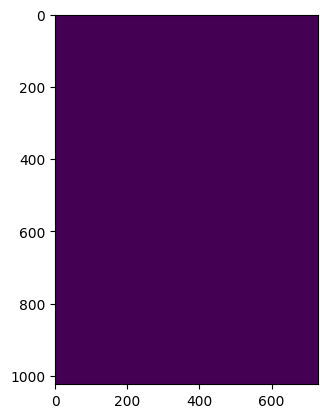

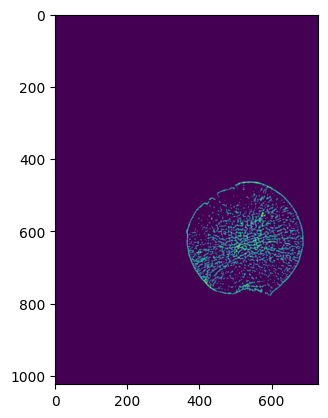

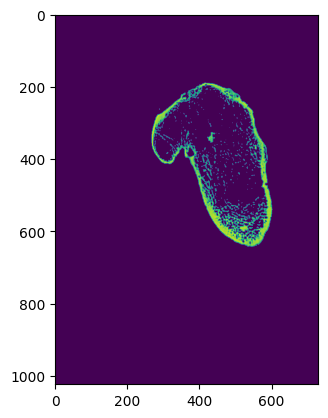

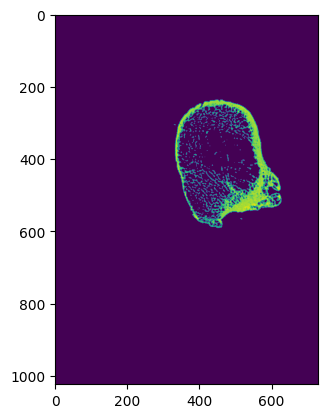

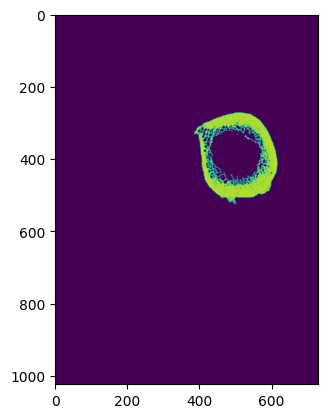

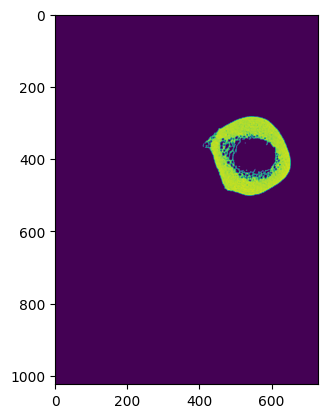

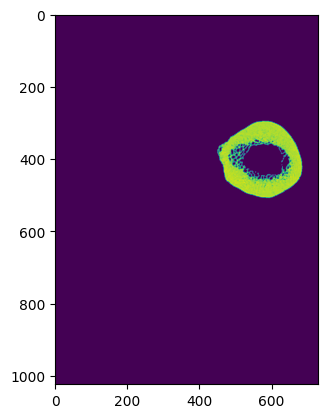

In [23]:
# Display some slices of the image
for i in range(0, image_cut.GetDepth(), 250):
    plt.imshow(sitk.GetArrayFromImage(thres[:,:,i]))
    plt.show()


In [24]:
sitk.WriteImage(thres, os.path.join(PCCT_image_path, "cutout_calibration_phantom_97.nii.gz"))

In [92]:
# Resample the image 
transform = sitk.ReadTransform(r"C:\Users\Yannick\Documents\repos\deep_femur_segmentation\data\transform2.txt")
# HR_pQCT_size = (1152, 1152, 125)

# extreme_points = [image.TransformIndexToPhysicalPoint((0,0,0)), 
#                   image.TransformIndexToPhysicalPoint((image.GetWidth(),0,0)),
#                   image.TransformIndexToPhysicalPoint((image.GetWidth(),image.GetHeight(),0)),
#                   image.TransformIndexToPhysicalPoint((0,image.GetHeight(),0)),
#                   image.TransformIndexToPhysicalPoint((0,0,image.GetDepth())), 
#                   image.TransformIndexToPhysicalPoint((image.GetWidth(),0,image.GetDepth())),
#                   image.TransformIndexToPhysicalPoint((image.GetWidth(),image.GetHeight(),image.GetDepth())),
#                   image.TransformIndexToPhysicalPoint((0,image.GetHeight(),image.GetDepth()))]

# inv_transform = transform.GetInverse()

# extreme_points = [inv_transform.TransformPoint(point) for point in extreme_points]
# min_x = min([point[0] for point in extreme_points])
# max_x = max([point[0] for point in extreme_points])
# min_y = min([point[1] for point in extreme_points])
# max_y = max([point[1] for point in extreme_points])
# min_z = min([point[2] for point in extreme_points])
# max_z = max([point[2] for point in extreme_points])

# output_spacing = image.GetSpacing()
# output_origin = [0, 0, 0]
# output_size = [int((max_x-min_x)/output_spacing[0]), int((max_y-min_y)/output_spacing[1]), int((max_z-min_z)/output_spacing[2])]

min_v=float(np.min(sitk.GetArrayFromImage(image[:,:,0:10])))

image_t = sitk.Resample(image, [1152, 1152, image.GetDepth()], transform, sitk.sitkLinear, [0,0,0], image.GetSpacing(), image.GetDirection(), defaultPixelValue=min_v)


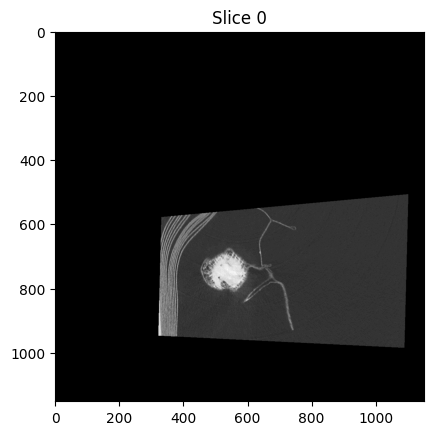

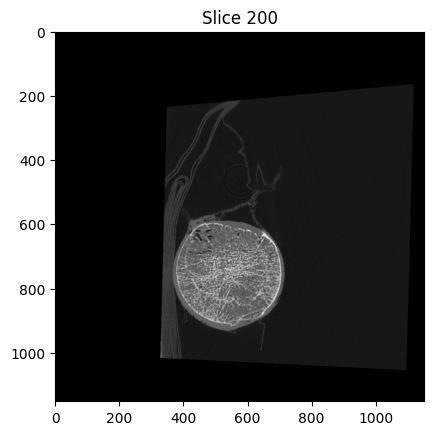

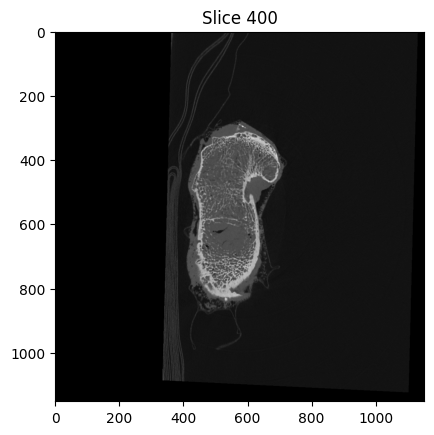

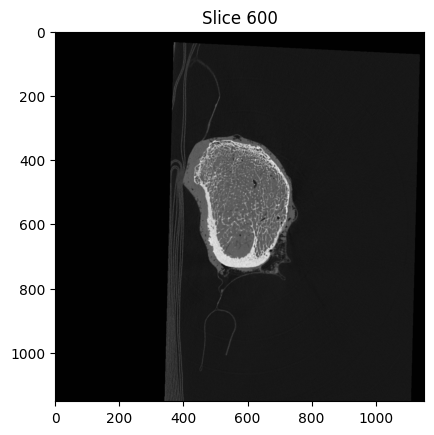

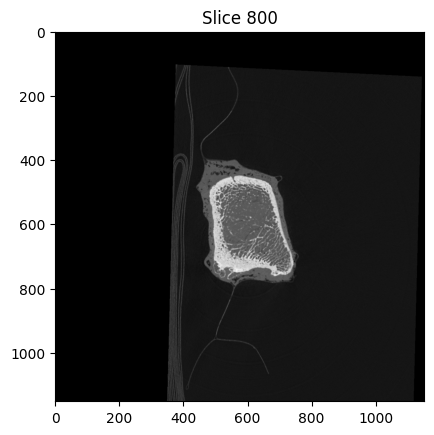

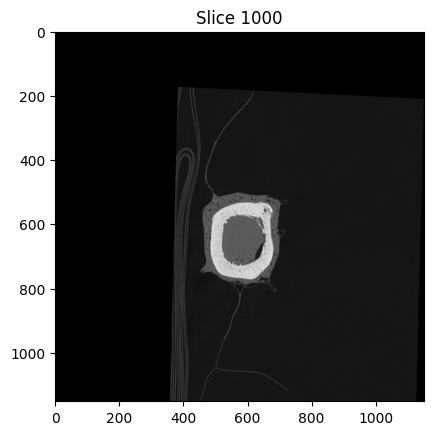

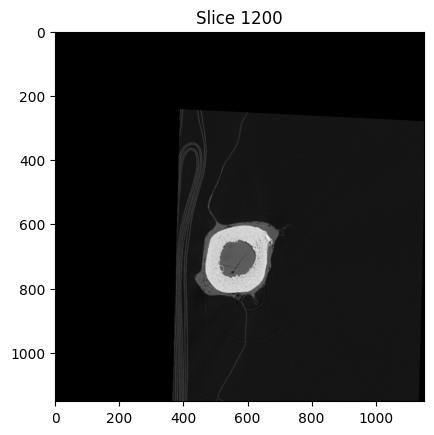

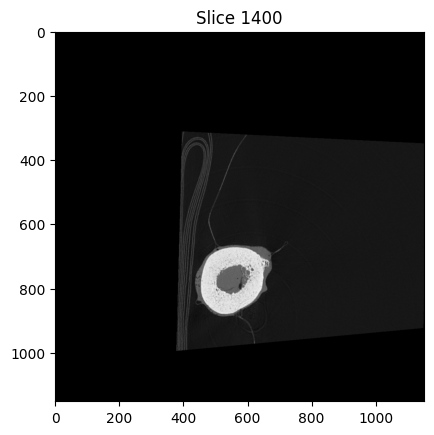

In [93]:
# Show slices
for i in range(0, image_t.GetDepth(), 200):
    plt.imshow(sitk.GetArrayFromImage(image_t[:,:,i]), cmap="gray")
    plt.title(f"Slice {i}")
    plt.show()

In [90]:
sitk.WriteImage(image_t, os.path.join(PCCT_image_path, "cutout_calibration_phantom_resample.nii.gz"))